In [1]:
import vilt2.config as config


# ========== Configuration varaible suatiablef or the current syntax ==========

# config = {
#     "data_root": data_root,  # Path to the directory containing the .arrow files
#     "num_workers": num_workers,
#     "batch_size": batch_size,
#     "image_size": image_size,
#     "max_text_len": max_text_len,
#     "draw_false_image": draw_false_image,
#     "draw_false_text": draw_false_text,
#     "image_only": image_only,
#     "tokenizer": tokenizer,
#     "mlm_prob": mlm_prob,
#     "whole_word_masking": whole_word_masking,
#     "val_transform_keys": val_transform_keys
# }



In [2]:
import torch
from torch.utils.data import DataLoader
from transformers import BertTokenizer
from vilt2.datasets.ood_nlvr2_dataset import OODNLVR2Dataset


def get_pretrained_tokenizer(from_pretrained):
    if torch.distributed.is_initialized():
        if torch.distributed.get_rank() == 0:
            BertTokenizer.from_pretrained(
                from_pretrained, do_lower_case="uncased" in from_pretrained
            )
        torch.distributed.barrier()
    return BertTokenizer.from_pretrained(
        from_pretrained, do_lower_case="uncased" in from_pretrained
    )

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained(config.tokenizer, do_lower_case="uncased" in config.tokenizer)


In [3]:
from transformers import DataCollatorForLanguageModeling

# Initialize the dataset
val_dataset = OODNLVR2Dataset(
    data_dir=config.data_root,
    transform_keys=config.val_transform_keys,
    image_size=config.image_size,
    # names=["nlvr2_vlue_test"],
    # text_column_name="questions",
    # remove_duplicate=False,
    # max_text_len=config["max_text_len"],
    # draw_false_image=config["draw_false_image"],
    # draw_false_text=config["draw_false_text"],
    # image_only=config["image_only"]
)

# Assign the tokenizer to the dataset
val_dataset.tokenizer = tokenizer

# Initialize the MLM collator
mlm_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm_probability=config.mlm_prob
)

# Define a wrapper function for the collate method
def collate_wrapper(batch):
    return val_dataset.collate(batch, mlm_collator)

# Create the DataLoader
val_dataloader = DataLoader(
    val_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=config.num_workers,
    pin_memory=True,
    collate_fn=collate_wrapper
)

# # Create the DataLoader
# val_dataloader = DataLoader(
#     val_dataset,
#     batch_size=config["batch_size"],
#     shuffle=False,
#     num_workers=config["num_workers"],
#     pin_memory=True,
#     collate_fn=val_dataset.collate
# )

/home/mileriso/thesis/dev/vilt2/datasets/ood_nlvr2_dataset.py:21: FutureWarning: promote has been superseded by promote_options='default'.
  super().__init__(


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


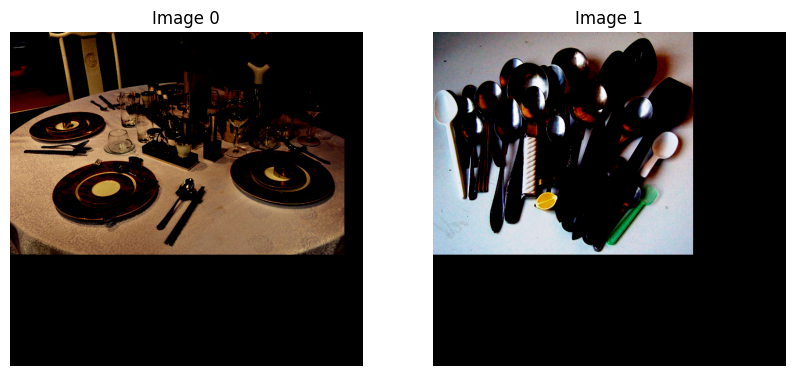

Text: The picture on the right shows the spoon alone, and the picture on the left shows the spoon and other cutlery
Answers: True


In [4]:
import matplotlib.pyplot as plt
import torch

# Get the first batch
first_batch = next(iter(val_dataloader))

# Extract the first element from the batch
first_element = {key: value[0] for key, value in first_batch.items()}

# Visualize the images
def show_image(image_tensor, title):
    image = image_tensor.permute(1, 2, 0).cpu().numpy()
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')

# Assuming the images are in 'image_0' and 'image_1'
image_0 = first_element['image_0'][0]  # First view of the first image
image_1 = first_element['image_1'][0]  # First view of the second image

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
show_image(image_0, 'Image 0')

plt.subplot(1, 2, 2)
show_image(image_1, 'Image 1')

plt.show()

# Print the text and answers
print("Text:", first_element['text'])
print("Answers:", first_element['answers'])

In [5]:
from vilt2.modules.vilt_module import ViLTransformerSS

model = ViLTransformerSS(config)

/home/mileriso/envs/.dev/lib/python3.10/site-packages/timm/models/helpers.py:7: FutureWarning: Importing from timm.models.helpers is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/home/mileriso/envs/.dev/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/mileriso/envs/.dev/lib/python3.10/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/home/mileriso/thesis/dev/vilt2/modules/vision_transformer.py:949: UserWarning: Overwriting vit_small_patch16_224 in registry with vilt2.modules.vi

In [6]:
# move each element of the fırst_batch to the GPU

# input = {key: value.to("cuda") if isinstance(value, torch.Tensor) else value for key, value in first_batch.items()}

# for key, value in input.items():
#     print(f"key: {key}, value: {value}")

input = first_batch

outputs = model(input)

 INFER----> The model is quantized: False
Quantization is not initialized
The input tensor is not contiguous. This will result in a copy and increase in memory usage.


/home/mileriso/envs/.dev/lib/python3.10/site-packages/transformers/models/bert/modeling_bert.py:228: UserWarning: The input tensor is not contiguous. This will result in a copy and increase in memory usage.
  warnings.warn(
/home/mileriso/envs/.dev/lib/python3.10/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


 INFER----> The model is quantized: False
Quantization is not initialized
The input tensor is not contiguous. This will result in a copy and increase in memory usage.


In [7]:
print(outputs.keys())

dict_keys(['nlvr2_loss', 'nlvr2_logits', 'nlvr2_labels', 'nlvr2_acc'])


In [8]:
print(outputs["nlvr2_labels"])
print(outputs["nlvr2_logits"])
print(outputs["nlvr2_loss"])
print(outputs["nlvr2_acc"])

tensor([1, 0, 0, 0, 1, 1, 0, 1, 1, 0])
tensor([[-0.7713, -0.4023],
        [ 3.1536, -2.8438],
        [-0.3630,  0.4203],
        [ 5.4898, -3.8450],
        [-4.5177,  4.3451],
        [ 2.1803, -1.9219],
        [ 3.2722, -2.3327],
        [-1.6310,  1.0998],
        [ 1.8411, -1.0888],
        [-1.1148,  0.4497]], grad_fn=<AddmmBackward0>)
tensor(1.0610, grad_fn=<NllLossBackward0>)
tensor(0.6000)


## Quantization

In [ ]:
import os
import copy

def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')

print("Size of the model before quantization")
print_size_of_model(model)

# this is the call that does the work
torch.quantization.quantize_dynamic(
    model, {torch.nn.Linear, torch.nn.LayerNorm, torch.nn.Conv2d}, dtype=torch.qint8, inplace=True
)

print("Size of the model after quantization")
print_size_of_model(model)

outputs = model(input)

print(outputs["nlvr2_labels"])
print(outputs["nlvr2_logits"])
print(outputs["nlvr2_loss"])
print(outputs["nlvr2_acc"])

Size of the model before quantization
Size (MB): 455.900658


AssertionError: Embedding quantization is only supported with float_qparams_weight_only_qconfig.

In [14]:
print(outputs["nlvr2_labels"])
print(outputs["nlvr2_logits"])
print(outputs["nlvr2_loss"])
print(outputs["nlvr2_acc"])

tensor([1, 0, 0, 0, 1, 1, 0, 1, 1, 0])
tensor([[-0.5898, -0.9421],
        [ 3.1010, -2.5737],
        [-0.0608, -0.0382],
        [ 1.0491, -0.2096],
        [-2.8830,  2.0490],
        [ 0.0248, -0.9799],
        [-0.0222, -0.4499],
        [-1.9131,  1.7156],
        [ 0.9338, -0.2832],
        [-0.2480, -0.8642]], grad_fn=<WarnNotImplemented>)
tensor(0.5603, grad_fn=<NllLossBackward0>)
tensor(0.6000)


In [ ]:
# import os
# import torch.quantization as quantization

# def print_size_of_model(model):
#     torch.save(model.state_dict(), "temp.p")
#     print('Size (MB):', os.path.getsize("temp.p")/1e6)
#     os.remove('temp.p')

# print("Size of the model before quantization")
# print_size_of_model(model)

# # Specify quantization configurations
# backend = "x86"
# torch.backends.quantized.engine = backend
# quantization_config = quantization.get_default_qconfig(backend)
# embedding_qconfig = quantization.QConfig(
#     activation=quantization.HistogramObserver.with_args(reduce_range=True),
#     weight=quantization.default_float_qparams_observer.with_args(dtype=torch.quint8)
# )

# # Set qconfig for each layer
# for _, module in model.named_modules():
#     if isinstance(module, torch.nn.LayerNorm):
#         # print(f"Skipping LayerNorm: {module}")
#         module.qconfig = None
#     elif isinstance(module, torch.nn.Embedding):
#         module.qconfig = embedding_qconfig
#     else:
#         module.qconfig = quantization_config

# # model.qconfig = quantization_config

# # model.qconfig = torch.quantization.QConfig(
# #                                       activation=quantization.observer.MovingAverageMinMaxObserver.with_args(reduce_range=True), 
# #                                       weight=quantization.observer.MovingAverageMinMaxObserver.with_args(dtype=torch.qint8, qscheme=torch.per_tensor_symmetric))



# # Prepare the model for quantization
# print(f"========== Preparing the model ==========")
# quantization.prepare(model, inplace=True)

# print(f"========== Calibrating the model ==========")
# outputs = model(input)

# print(f"========== Converting the model ==========")
# # Convert the model to a quantized version
# quantization.convert(model, inplace=True)

# print("Size of the model after quantization")
# print_size_of_model(model)

# model.init_quantization()

# outputs = model(input)

# print(f"Size of the quantized model")
# # print_size_of_model(model_converted)

Size of the model before quantization
Size (MB): 455.900658
========== Preparing the model ==========
========== Calibrating the model ==========
 INFER----> The model is quantized: False
Quantization is not initialized
The input tensor is not contiguous. This will result in a copy and increase in memory usage.


/home/mileriso/envs/.dev/lib/python3.10/site-packages/torch/ao/quantization/observer.py:229: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


 INFER----> The model is quantized: False
Quantization is not initialized
The input tensor is not contiguous. This will result in a copy and increase in memory usage.
========== Converting the model ==========
Size of the model after quantization
Size (MB): 116.418042
Quantization initialized for BERT Model.
Quantization initialized for ViT model
 INFER----> The model is quantized: True
Data type of text_ids in main model class: torch.int64
The input tensor is not contiguous. This will result in a copy and increase in memory usage.


NotImplementedError: Could not run 'quantized::conv2d.new' with arguments from the 'CPU' backend. This could be because the operator doesn't exist for this backend, or was omitted during the selective/custom build process (if using custom build). If you are a Facebook employee using PyTorch on mobile, please visit https://fburl.com/ptmfixes for possible resolutions. 'quantized::conv2d.new' is only available for these backends: [Meta, QuantizedCPU, QuantizedCUDA, BackendSelect, Python, FuncTorchDynamicLayerBackMode, Functionalize, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradXLA, AutogradMPS, AutogradXPU, AutogradHPU, AutogradLazy, AutogradMeta, Tracer, AutocastCPU, AutocastXPU, AutocastMPS, AutocastCUDA, FuncTorchBatched, BatchedNestedTensor, FuncTorchVmapMode, Batched, VmapMode, FuncTorchGradWrapper, PythonTLSSnapshot, FuncTorchDynamicLayerFrontMode, PreDispatch, PythonDispatcher].

Meta: registered at ../aten/src/ATen/core/MetaFallbackKernel.cpp:23 [backend fallback]
QuantizedCPU: registered at ../aten/src/ATen/native/quantized/cpu/qconv.cpp:1972 [kernel]
QuantizedCUDA: registered at ../aten/src/ATen/native/quantized/cudnn/Conv.cpp:391 [kernel]
BackendSelect: fallthrough registered at ../aten/src/ATen/core/BackendSelectFallbackKernel.cpp:3 [backend fallback]
Python: registered at ../aten/src/ATen/core/PythonFallbackKernel.cpp:153 [backend fallback]
FuncTorchDynamicLayerBackMode: registered at ../aten/src/ATen/functorch/DynamicLayer.cpp:497 [backend fallback]
Functionalize: registered at ../aten/src/ATen/FunctionalizeFallbackKernel.cpp:349 [backend fallback]
Named: registered at ../aten/src/ATen/core/NamedRegistrations.cpp:7 [backend fallback]
Conjugate: registered at ../aten/src/ATen/ConjugateFallback.cpp:17 [backend fallback]
Negative: registered at ../aten/src/ATen/native/NegateFallback.cpp:18 [backend fallback]
ZeroTensor: registered at ../aten/src/ATen/ZeroTensorFallback.cpp:86 [backend fallback]
ADInplaceOrView: fallthrough registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:96 [backend fallback]
AutogradOther: registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:63 [backend fallback]
AutogradCPU: registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:67 [backend fallback]
AutogradCUDA: registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:75 [backend fallback]
AutogradXLA: registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:79 [backend fallback]
AutogradMPS: registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:87 [backend fallback]
AutogradXPU: registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:71 [backend fallback]
AutogradHPU: registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:100 [backend fallback]
AutogradLazy: registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:83 [backend fallback]
AutogradMeta: registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:91 [backend fallback]
Tracer: registered at ../torch/csrc/autograd/TraceTypeManual.cpp:294 [backend fallback]
AutocastCPU: fallthrough registered at ../aten/src/ATen/autocast_mode.cpp:321 [backend fallback]
AutocastXPU: fallthrough registered at ../aten/src/ATen/autocast_mode.cpp:463 [backend fallback]
AutocastMPS: fallthrough registered at ../aten/src/ATen/autocast_mode.cpp:209 [backend fallback]
AutocastCUDA: fallthrough registered at ../aten/src/ATen/autocast_mode.cpp:165 [backend fallback]
FuncTorchBatched: registered at ../aten/src/ATen/functorch/LegacyBatchingRegistrations.cpp:731 [backend fallback]
BatchedNestedTensor: registered at ../aten/src/ATen/functorch/LegacyBatchingRegistrations.cpp:758 [backend fallback]
FuncTorchVmapMode: fallthrough registered at ../aten/src/ATen/functorch/VmapModeRegistrations.cpp:27 [backend fallback]
Batched: registered at ../aten/src/ATen/LegacyBatchingRegistrations.cpp:1075 [backend fallback]
VmapMode: fallthrough registered at ../aten/src/ATen/VmapModeRegistrations.cpp:33 [backend fallback]
FuncTorchGradWrapper: registered at ../aten/src/ATen/functorch/TensorWrapper.cpp:207 [backend fallback]
PythonTLSSnapshot: registered at ../aten/src/ATen/core/PythonFallbackKernel.cpp:161 [backend fallback]
FuncTorchDynamicLayerFrontMode: registered at ../aten/src/ATen/functorch/DynamicLayer.cpp:493 [backend fallback]
PreDispatch: registered at ../aten/src/ATen/core/PythonFallbackKernel.cpp:165 [backend fallback]
PythonDispatcher: registered at ../aten/src/ATen/core/PythonFallbackKernel.cpp:157 [backend fallback]


In [ ]:
a = torch.rand(1, 3, 224, 224)
a.qconfig = torch.quantization.default_qconfig

print(f"Datatype of the input: {a.dtype}")

a = torch.quantization.QuantStub()(a)

print(f"Datatype of the input after quantization: {a.dtype}")

Datatype of the input: torch.float32
Datatype of the input after quantization: torch.float32
